In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2021_altın_mudahale/preprocessed_twitter_2021_altın_mudahale.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"50,000 finnish industrial workers threaten str...",0.000000,0.000000,Neutral
1,1,happened btc$100k eoy 🤷‍♂️ reminds fools gold ...,0.000000,0.000000,Neutral
2,2,plop supercooled ice 💦 copper gold swimmingspo...,0.400000,-0.150000,Negative
3,3,jp morgan turns bearish anything-- especially ...,1.000000,0.000000,Neutral
4,4,2021 year clean energy finally faced mining pr...,0.679451,0.157656,Positive


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     4992
Positive    3088
Negative     848
Name: Analysis, dtype: int64
Total comments:  8928


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :48


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

<ipython-input-10-3ebf70ccd52a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-3ebf70ccd52a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
print(train_labels[:10])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [14]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [15]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
252/252 [==============================] - 10s 36ms/step - loss: 0.4612 - accuracy: 0.8363 - auc: 0.9607 - val_loss: 0.1205 - val_accuracy: 0.9698 - val_auc: 0.9985
Epoch 2/10
252/252 [==============================] - 8s 31ms/step - loss: 0.0571 - accuracy: 0.9935 - auc: 0.9992 - val_loss: 0.0392 - val_accuracy: 0.9966 - val_auc: 1.0000
Epoch 3/10
252/252 [==============================] - 9s 36ms/step - loss: 0.0254 - accuracy: 0.9993 - auc: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9966 - val_auc: 0.9994
Epoch 4/10
252/252 [==============================] - 8s 31ms/step - loss: 0.0168 - accuracy: 0.9998 - auc: 0.9999 - val_loss: 0.0270 - val_accuracy: 0.9966 - val_auc: 0.9986
Epoch 5/10
252/252 [==============================] - 9s 35ms/step - loss: 0.0105 - accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9966 - val_auc: 0.9983
Epoch 6/10
252/252 [==============================] - 8s 33ms/step - loss: 0.0082 - accuracy: 1.0000 - auc: 1.0000 - val_los

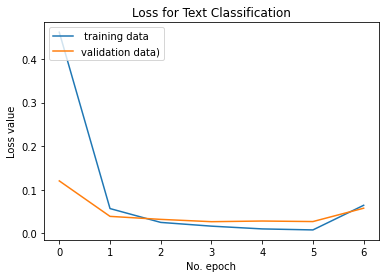

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

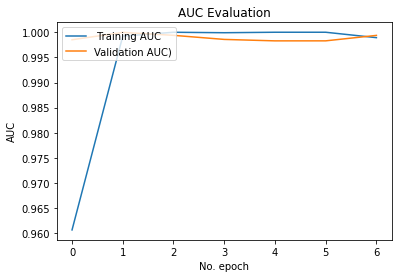

In [17]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
X_test

7624    7 reasons invest gold 👉 goldira gold smartinve...
994     expensive you, disagree ;scan barcode. hint: o...
7577    live goldprice spot gold trading $1803.3 usd, ...
6967    live goldprice spot gold trading $1816.7 usd, ...
6632    gold nosedives rs1,200 tola domestic bullion -...
                              ...                        
3994    card payment systems gwynedd | contactless por...
2076    trading signal brent : oil giving days rise. l...
1644    question? influenced? influences buy? buy want...
8009                                     الذهب xauusd adx
4860                                                cheap
Name: tweet, Length: 893, dtype: object

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-19-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
28/28 [==============================] - 0s 4ms/step


array([1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2,
       1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1,
       2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2,

In [21]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [22]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      0.99      1.00       310
    Negative       1.00      0.99      0.99        85
     Neutral       0.99      1.00      1.00       498

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893

